# ニューラルネット

Python は，豊富なライブラリを備えています。特に，ニューラルネットワークなどの機械学習のライブラリが充実しています。機械学習の仕組みの詳細を知らなくても，データを揃えてライブラリを呼び出せば，ある程度のことができる状態になっています。文字認識のニューラルネットを題材に，その使い方を説明します。

ニューラルネットのライブラリとしては，オープンソースのPyTorch が広く使われています。
その前には、Google が開発したオープンソースのシステムである TensorFlow が有名でした。さらに，Tensorflow のニューラルネットワークを組むための高レベルのライブラリである Keras を用いると，見よう見まねで，ある程度の機械学習を行えます。

ここでは、Pytorchを用いて説明をします。PyTorchは標準ではインストールされていません。pip を用いてインストールします。

Pytorchはパッケージのサイズが大きいため、PCの容量が足りない場合google colabを利用することをお勧めします。軽量版であるPyTorch Lightningを用いることもできますが、今回はPyTorchを用いて説明します。



以下のサイトを参考に使用しているPCに合わせたインストールコマンドを取得して実行してください。

https://pytorch.org/

TAは以下の設定でインストールしました。
<img src="13image_1.png" width="700">

今回は以下のサイトを参考に、mnistのデータセットを用いて文字認識を教師在り学習で行います。
https://github.com/pytorch/examples/blob/main/mnist/main.py

以下の図が概観です。

今回の目的は、適当に初期化されたモデルが文字認識を行えるように学習することです。学習は訓練データを用いてモデルのパラメータを更新することで行います。訓練データに対して正しい出力を返すようになったモデルは、未知のデータに対しても正しい出力を返すことが期待されます。

学習の大まかな流れは、データの前処理の後、(1)モデルの予想、(2)正解との誤差の計算、(3)パラメータの更新の繰り返しです。

<img src="13image_2.png" width="700">

mnist は，手書きの数字のテストデータとして広く使われているデータです。torchvision.datasets.MNISTの呼び出しで，ネットからダウンロードできます。
今回はダウンロードしたデータは/data フォルダに保存されます。

mnist のデータは，28x28 の画像データで、0 から 9 までの数字が書かれています。

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [12]:
# MNISTデータをダウンロードする
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
training_set = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
validation_set = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

In [13]:
print(training_set)
print(validation_set)

print("train data: ", training_set.data.shape, training_set.targets.shape, training_set.data.dtype, training_set.targets.dtype)
print("test data: ", validation_set.data.shape, validation_set.targets.shape, validation_set.data.dtype, validation_set.targets.dtype)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
train data:  torch.Size([60000, 28, 28]) torch.Size([60000]) torch.uint8 torch.int64
test data:  torch.Size([10000, 28, 28]) torch.Size([10000]) torch.uint8 torch.int64


このように，training_set.data, validation_set.data には，28x28 の unit 8 の配列がそれぞれ60,000枚, 10,000枚入っています。これらが手書きの画像です。unit 8 は，符号なしビットビット整数(0 から 255 まで) です。

training_set.targets, validation_set.targets には，int64の数が入っています。これは画像に対する正解ラベルで，対応するインデックスのデータが0 から 9 までのどの文字かを表しています。

文字は次のようにして表示できます。

label:  5


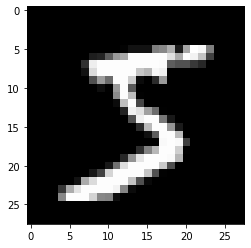

In [14]:
# 0番目のデータの表示
%matplotlib inline
plt.imshow(training_set.data[0].numpy(), cmap='gray')
print("label: ", training_set.targets[0].item())

PytorchではDataLoaderを用いてデータを読み込みます。DataLoaderはデータをバッチサイズに分割して読み込むことができます。

In [15]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size)

次に、ニューラルネットをモデルとして組みます。
最初は，入力層と出力層だけがあり，それが全結合でつながったもので試しましょう。ニューラルネットワークは重みを最適化することで学習します。

以下はニューラルネットワークのイメージ図です。
<img src="13image_3.png" width="700">

28*28の画像を728次元のベクトルに変換し、重みをかけて出力を得ます。
重みは行列$W \in \mathbb{R}^{10×728}$で表され、入力$x$に対し出力$y$は$y=W x$で表されます。

In [16]:
# モデルの構築
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28, 10, bias=False),
)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

学習を行いましょう。データを batch_size で指定された長さのバッチに分けて，バッチごとに学習します。学習は行列計算で実現されるので，ある程度の量のデータを一度に処理した方が効率が良いです。

学習では重み$W$を最適化します。モデルの予測ラベルと正解ラベルの誤差を計算し、その誤差を最小化するように重みを更新します。

全データに対する学習を，epochs で指定された回数繰り返します。
繰り返すごとに，性能があがっていきます。loss の値が下がり，accuracy の値が上がっていきます。

In [17]:
# 学習
def train(model, train_loader, optimizer, loss_fn, epoch):
    model.train()
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if (i + 1) % 300 == 0:
            print(f'Train Epoch: {epoch} [{i * len(images)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    train_loss /= len(train_loader.dataset)
    return train_loss


def test(model, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            output = model(images)
            test_loss += loss_fn(output, labels).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(labels).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')
    return test_loss, correct / len(test_loader.dataset)


epochs = 20
history = {"train_loss": [], "test_loss": [], "acc": []}
for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader, optimizer, loss_fn, epoch)
    test_loss, acc = test(model, test_loader, loss_fn)
    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["acc"].append(acc)

Train Epoch: 1 [19136/60000 (32%)]	Loss: 0.319888
Train Epoch: 1 [38336/60000 (64%)]	Loss: 0.762979
Train Epoch: 1 [57536/60000 (96%)]	Loss: 0.335796

Test set: Average loss: 0.0110, Accuracy: 8928/10000 (89%)

Train Epoch: 2 [19136/60000 (32%)]	Loss: 0.326168
Train Epoch: 2 [38336/60000 (64%)]	Loss: 0.816070
Train Epoch: 2 [57536/60000 (96%)]	Loss: 0.814866

Test set: Average loss: 0.0113, Accuracy: 8947/10000 (89%)

Train Epoch: 3 [19136/60000 (32%)]	Loss: 0.273045
Train Epoch: 3 [38336/60000 (64%)]	Loss: 0.735009
Train Epoch: 3 [57536/60000 (96%)]	Loss: 0.636936

Test set: Average loss: 0.0120, Accuracy: 8883/10000 (89%)

Train Epoch: 4 [19136/60000 (32%)]	Loss: 0.263583
Train Epoch: 4 [38336/60000 (64%)]	Loss: 0.637812
Train Epoch: 4 [57536/60000 (96%)]	Loss: 0.235542

Test set: Average loss: 0.0137, Accuracy: 8800/10000 (88%)

Train Epoch: 5 [19136/60000 (32%)]	Loss: 0.189679
Train Epoch: 5 [38336/60000 (64%)]	Loss: 0.692851
Train Epoch: 5 [57536/60000 (96%)]	Loss: 0.301817

Test 

テストデータで検証し、validation_setの0番目のデータを使って正しい答えが出ているかを見てみましょう。

In [18]:
_ = test(model, test_loader, loss_fn)


Test set: Average loss: 0.0161, Accuracy: 8686/10000 (87%)



predict: 7 asnwer: 7


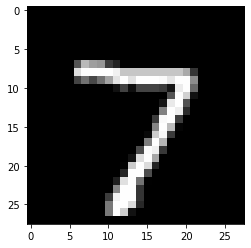

In [19]:
%matplotlib inline
import torchvision.transforms.functional

# ニューラルネットに入力するためにtransformと同じ処理をする
image = torchvision.transforms.functional.normalize(torchvision.transforms.functional.to_tensor(validation_set.data[0].numpy()), (0.1307,), (0.3081,))

model.eval()
p = model(image.unsqueeze(0))
print("predict:", p.argmax().item(), "asnwer:", validation_set.targets[0].item())
plt.imshow(validation_set.data[0].numpy(), cmap='gray')

100個のデータを使って正答率を計算し、間違っているもののデータを見てみます。

In [20]:
# 100個分のテスト
images = [torchvision.transforms.functional.normalize(torchvision.transforms.functional.to_tensor(validation_set.data[i].numpy()), (0.1307,), (0.3081,)) for i in range(100)]
labels = validation_set.targets[:100]

model.eval()
p = model(torch.stack(images))
answer = p.argmax(dim=1)
correct = answer.eq(labels).sum().item()
print(f'Accuracy: {correct}/100')
print("Wrong answers: ", [i for i in range(100) if answer[i] != labels[i]])

Accuracy: 91/100
Wrong answers:  [1, 8, 18, 33, 38, 66, 78, 80, 92]


tensor([56.8063, 16.6135, 38.0563, 16.9449, 68.4404, 59.9757, 82.5035,  0.3943,
        53.6186, 45.3252], grad_fn=<SelectBackward0>)
predict: 6 asnwer: 5


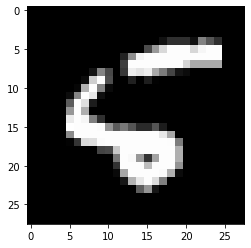

In [21]:
%matplotlib inline
index = 8
print(p[index])
print("predict:", p[index].argmax().item(), "asnwer:", labels[index].item())
plt.imshow(validation_set.data[index].numpy(), cmap='gray')


ネットワークを組み替えて，より高機能にしましょう。具体的には，モデルに中間層として，全結合で，relu という活性化関数をもったものを追加します。層のセルの数は 128 にしましたが，これが最適かどうかは分かりません。いろんなパラメータ（ハイパーパラメータといいます）を経験に基づいて設定していく必要があります。

In [22]:
model2 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
)
optimizer2 = torch.optim.RMSprop(model2.parameters(), lr=0.01)


# 学習
history2 = {"train_loss": [], "test_loss": [], "acc": []}
epochs = 20
for epoch in range(1, epochs + 1):
    train_loss = train(model2, train_loader, optimizer2, loss_fn, epoch)
    test_loss, acc = test(model2, test_loader, loss_fn)
    history2["train_loss"].append(train_loss)
    history2["test_loss"].append(test_loss)
    history2["acc"].append(acc)

_ = test(model2, test_loader, loss_fn)

Train Epoch: 1 [19136/60000 (32%)]	Loss: 0.178582
Train Epoch: 1 [38336/60000 (64%)]	Loss: 0.424805
Train Epoch: 1 [57536/60000 (96%)]	Loss: 0.130150

Test set: Average loss: 0.0055, Accuracy: 9129/10000 (91%)

Train Epoch: 2 [19136/60000 (32%)]	Loss: 0.155700
Train Epoch: 2 [38336/60000 (64%)]	Loss: 0.233027
Train Epoch: 2 [57536/60000 (96%)]	Loss: 0.029722

Test set: Average loss: 0.0044, Accuracy: 9323/10000 (93%)

Train Epoch: 3 [19136/60000 (32%)]	Loss: 0.063713
Train Epoch: 3 [38336/60000 (64%)]	Loss: 0.259748
Train Epoch: 3 [57536/60000 (96%)]	Loss: 0.043743

Test set: Average loss: 0.0050, Accuracy: 9241/10000 (92%)

Train Epoch: 4 [19136/60000 (32%)]	Loss: 0.057434
Train Epoch: 4 [38336/60000 (64%)]	Loss: 0.205117
Train Epoch: 4 [57536/60000 (96%)]	Loss: 0.112240

Test set: Average loss: 0.0055, Accuracy: 9348/10000 (93%)

Train Epoch: 5 [19136/60000 (32%)]	Loss: 0.240376
Train Epoch: 5 [38336/60000 (64%)]	Loss: 0.146479
Train Epoch: 5 [57536/60000 (96%)]	Loss: 0.251919

Test 

先程より，さらに結果がよくなりました。
学習過程において，train_loss (損失値，この値が低いほどよい) と test_loss (テストデータに対する損失値)の値がどう変化したかをグラフ化します。

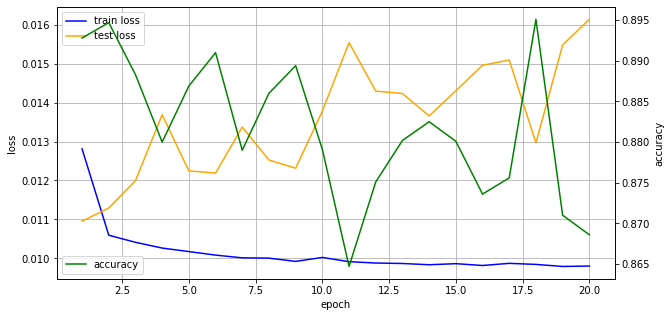

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

train_loss = history["train_loss"]
test_loss = history["test_loss"]
acc = history["acc"]

fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(range(1, epochs + 1), train_loss, label='train loss', color='blue')
ax1.plot(range(1, epochs + 1), test_loss, label='test loss', color='orange')
ax2.plot(range(1, epochs + 1), acc, label='accuracy', color='green')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax2.set_ylabel('accuracy')
ax1.legend()
ax2.legend()
ax1.grid()
plt.show()

train_lossの値は下がっていますが、test_lossの値は上がっているようです。これは，過学習している（すなわち，訓練データに合わせすぎて汎用性がなくなってきている）と思われます。

history2 も重ねてみましょう。

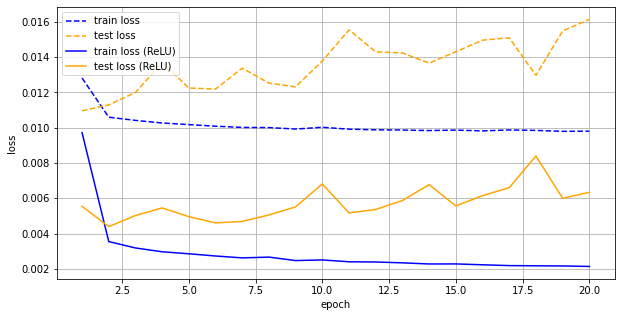

In [24]:
train_loss = history["train_loss"]
test_loss = history["test_loss"]

train_loss2 = history2["train_loss"]
test_loss2 = history2["test_loss"]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, epochs + 1), train_loss, label='train loss', color='blue', linestyle='dashed')
ax.plot(range(1, epochs + 1), test_loss, label='test loss', color='orange', linestyle='dashed')
ax.plot(range(1, epochs + 1), train_loss2, label='train loss (ReLU)', color='blue')
ax.plot(range(1, epochs + 1), test_loss2, label='test loss (ReLU)', color='orange')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.grid()
plt.show()

訓練データに対しては値がどんどんよくなっているのに，テストデータに対しては悪くなってきているのは，過学習の特徴です。

次はoptimizerを変えてみましょう。今回はAdadelataを用いて学習を行います。

In [25]:
model3 = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
)
optimizer3 = torch.optim.Adadelta(model3.parameters(), lr=1.0)
scheduler3 = StepLR(optimizer3, step_size=1, gamma=0.7)

# 学習
history3 = {"train_loss": [], "test_loss": [], "acc": []}
epochs = 20
for epoch in range(1, epochs + 1):
    train_loss = train(model3, train_loader, optimizer3, loss_fn, epoch)
    test_loss, acc = test(model3, test_loader, loss_fn)
    history3["train_loss"].append(train_loss)
    history3["test_loss"].append(test_loss)
    history3["acc"].append(acc)
    scheduler3.step()

Train Epoch: 1 [19136/60000 (32%)]	Loss: 0.126669
Train Epoch: 1 [38336/60000 (64%)]	Loss: 0.122137
Train Epoch: 1 [57536/60000 (96%)]	Loss: 0.016137

Test set: Average loss: 0.0018, Accuracy: 9655/10000 (97%)

Train Epoch: 2 [19136/60000 (32%)]	Loss: 0.055983
Train Epoch: 2 [38336/60000 (64%)]	Loss: 0.088539
Train Epoch: 2 [57536/60000 (96%)]	Loss: 0.004704

Test set: Average loss: 0.0014, Accuracy: 9729/10000 (97%)

Train Epoch: 3 [19136/60000 (32%)]	Loss: 0.017716
Train Epoch: 3 [38336/60000 (64%)]	Loss: 0.067880
Train Epoch: 3 [57536/60000 (96%)]	Loss: 0.003284

Test set: Average loss: 0.0013, Accuracy: 9757/10000 (98%)

Train Epoch: 4 [19136/60000 (32%)]	Loss: 0.008557
Train Epoch: 4 [38336/60000 (64%)]	Loss: 0.054785
Train Epoch: 4 [57536/60000 (96%)]	Loss: 0.002931

Test set: Average loss: 0.0012, Accuracy: 9760/10000 (98%)

Train Epoch: 5 [19136/60000 (32%)]	Loss: 0.006200
Train Epoch: 5 [38336/60000 (64%)]	Loss: 0.052573
Train Epoch: 5 [57536/60000 (96%)]	Loss: 0.002387

Test 

history3をhistory2と比較してみましょう。

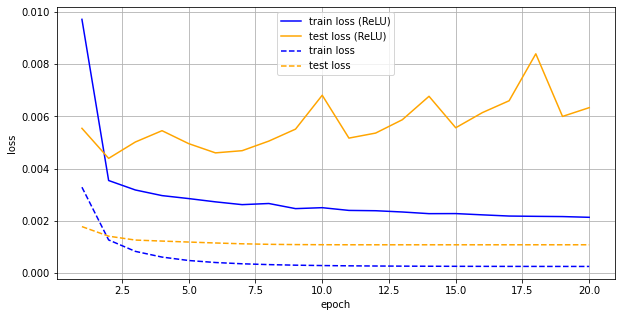

In [26]:
train_loss2 = history2["train_loss"]
test_loss2 = history2["test_loss"]

train_loss3 = history3["train_loss"]
test_loss3 = history3["test_loss"]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, epochs + 1), train_loss2, label='train loss (ReLU)', color='blue')
ax.plot(range(1, epochs + 1), test_loss2, label='test loss (ReLU)', color='orange')
ax.plot(range(1, epochs + 1), train_loss3, label='train loss', color='blue', linestyle='dashed')
ax.plot(range(1, epochs + 1), test_loss3, label='test loss', color='orange', linestyle='dashed')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.grid()
plt.show()

optimizerを変えるだけで、学習の結果が変わることがわかります。